# Setup

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import CIFAR100

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm, trange

In [2]:
from torch import accelerator

device = accelerator.current_accelerator().type if accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Loading CIFAR-100 (5 points)

Let's begin by loading the [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).
**Don't normalize the dataset.**

In [3]:
transform = transforms.ToTensor()

trainset = CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = CIFAR100(root='./data', train=False, download=True, transform=transform)

# TODO: Create loaders
batch_size = 128
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


classes = testset.classes

100%|██████████| 169M/169M [00:04<00:00, 39.7MB/s]


Now visualize some images from this dataset.

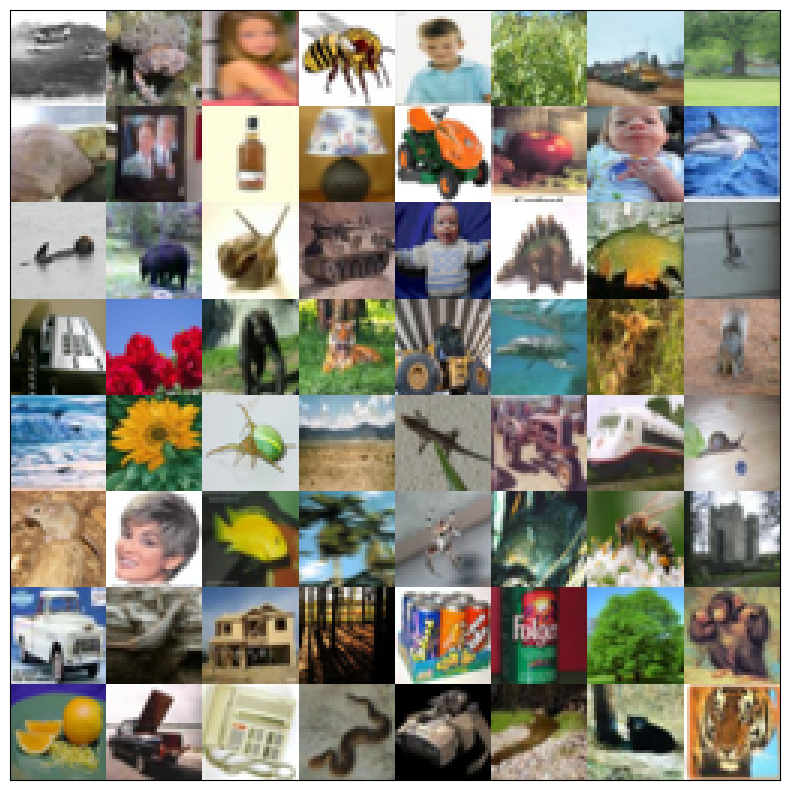

In [4]:
from torchvision.utils import make_grid

def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([]), plt.yticks([])
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images[:64], nrow=8, padding=0))

# Training (10 points)

In this section we'll train a [PreActResNet18](https://arxiv.org/abs/1603.05027) on the [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

In [5]:
# @title PreActResNet

'''Pre-activation ResNet in PyTorch.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Identity Mappings in Deep Residual Networks. arXiv:1603.05027
'''

class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()

        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            downsample_conv = nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            self.shortcut = nn.Sequential(downsample_conv)

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            downsample_conv = nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes: int = 100, in_channels: int = 3):
        super(PreActResNet, self).__init__()

        self.in_planes = 64
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.bn = nn.BatchNorm2d(512 * block.expansion)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.relu(self.bn(out))
        out = F.avg_pool2d(out, out.shape[-1])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def PreActResNet18(**kwargs):
    return PreActResNet(PreActBlock, [2,2,2,2], **kwargs)

def PreActResNet34(**kwargs):
    return PreActResNet(PreActBlock, [3,4,6,3], **kwargs)

def PreActResNet50(**kwargs):
    return PreActResNet(PreActBottleneck, [3,4,6,3], **kwargs)

def PreActResNet101(**kwargs):
    return PreActResNet(PreActBottleneck, [3,4,23,3], **kwargs)

def PreActResNet152(**kwargs):
    return PreActResNet(PreActBottleneck, [3,8,36,3], **kwargs)

In [6]:
def train(model, optimizer, loader, n_epochs: int = 15):
    accuracies = np.zeros(n_epochs)

    # Enter training mode
    model.train()

    # Define loss function
    loss_fn = nn.CrossEntropyLoss()

    # Iterate over epochs
    for epoch in (pbar := trange(n_epochs)):
        correct, total = 0, 0

        # TODO: Iterate over loader
        for x, y in tqdm(loader, leave=False):

            # TODO: Move batch to device
            x = x.to(device)
            y = y.to(device)

            # TODO: Compute prediction error
            optimizer.zero_grad()
            outputs = model(x)
            loss = loss_fn(outputs, y)

            # TODO: Backpropagation
            loss.backward()
            optimizer.step()

            # TODO: Update counters
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        accuracies[epoch] = 100 * correct / total
        pbar.set_description(f'Accuracy {accuracies[epoch]:.2f}%')

    return accuracies

Train the model and plot the accuracies.

In [7]:
model = PreActResNet18().to(device)
optimizer = Adam(model.parameters())

accuracies = train(model, optimizer, trainloader)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

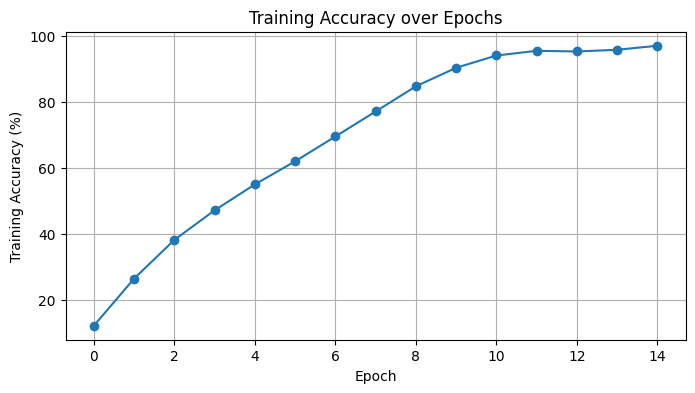

In [8]:
# TODO: Plot accuracies
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(accuracies)), accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy (%)')
plt.title('Training Accuracy over Epochs')
plt.grid(True)
plt.show()

In [9]:
# Optional: Save model
torch.save(model, 'model.pth')

# Evaluation (10 points)

Now we evaluate the model.
Here we also allow the `evaluate` function to have an `attack` parameter.
The `attack` function takes in the model, the images and true labels and outputs the adversarial examples.
It can also take in a dictionary of parameters, called `attack_params`, which allows us to pass additional values for the attack such as the epsilon values.

In [10]:
# @title Plot the confusion matrix

def plot_confusion_matrix(confusion_matrix, title='Confusion Matrix'):
    """
    Plot a confusion matrix with class names, normalized colors, and cell counts.

    Args:
        confusion_matrix: 2D numpy array of shape [num_classes, num_classes]
        classes: tuple of class names
        title: title for the plot
    """
    num_classes = len(classes)

    # Calculate row-wise normalization (percentage of each true class)
    row_sums = confusion_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    normalized_matrix = confusion_matrix.astype('float') / row_sums

    # Create the plot
    plt.figure(figsize=(30, 28))
    ax = sns.heatmap(normalized_matrix,
                     annot=False,  # We'll add custom annotations
                     fmt='.2f',
                     cmap='Blues',
                     cbar_kws={'label': 'Normalized Percentage'},
                     square=True,
                     xticklabels=classes,
                     yticklabels=classes)

    # Add the actual counts as text on each cell
    for i in range(num_classes):
        for j in range(num_classes):
            # Only add text if there are samples in this cell
            if confusion_matrix[i, j] > 0:
                text_color = 'white' if normalized_matrix[i, j] > 0.5 else 'black'
                ax.text(j + 0.5, i + 0.5, f'{confusion_matrix[i, j]}',
                        ha='center', va='center',
                        color=text_color, fontweight='bold')

    # Set labels and title
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(title, fontsize=14, pad=20)

    # Rotate tick labels for better readability
    plt.xticks(rotation=90, ha='right')
    plt.yticks(rotation=0)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [11]:
def evaluate(model, loader, attack=None, attack_params=dict(), batch_count=-1):
    correct, total = 0, 0
    # Initialize confusion matrix
    num_classes = len(classes)
    confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64, device=device)

    # TODO: Enter evaluation mode
    model.eval()

    # Iterate over loader
    for x, y in (pbar := tqdm(loader)):
        # TODO: Move batch to device
        x = x.to(device)
        y = y.to(device)

        # TODO: Perform attack
        if attack is not None:
            x_adv = attack(model, x, y, **attack_params)
            if isinstance(x_adv, tuple) or isinstance(x_adv, list):
                x_adv = x_adv[-1]
        else:
            x_adv = x

        # TODO: Predict output
        with torch.no_grad():
            outputs = model(x_adv)
            preds = outputs.argmax(dim=1)

        # TODO: Update counters
        correct += (preds == y).sum().item()
        total += y.size(0)

        # TODO: Update confusion matrix
        for true_label, pred_label in zip(y, preds):
            confusion_matrix[true_label.long(), pred_label.long()] += 1

        pbar.set_description(f'Accuracy {100 * correct / total :.2f}%')

        batch_count -= 1
        if batch_count == 0:
            break

    # TODO: Return accuracy and confusion matrix
    if total > 0:
        accuracy = torch.tensor(100.0 * correct / total, device=device)

    return accuracy.item(), confusion_matrix.cpu().numpy()

  0%|          | 0/79 [00:00<?, ?it/s]

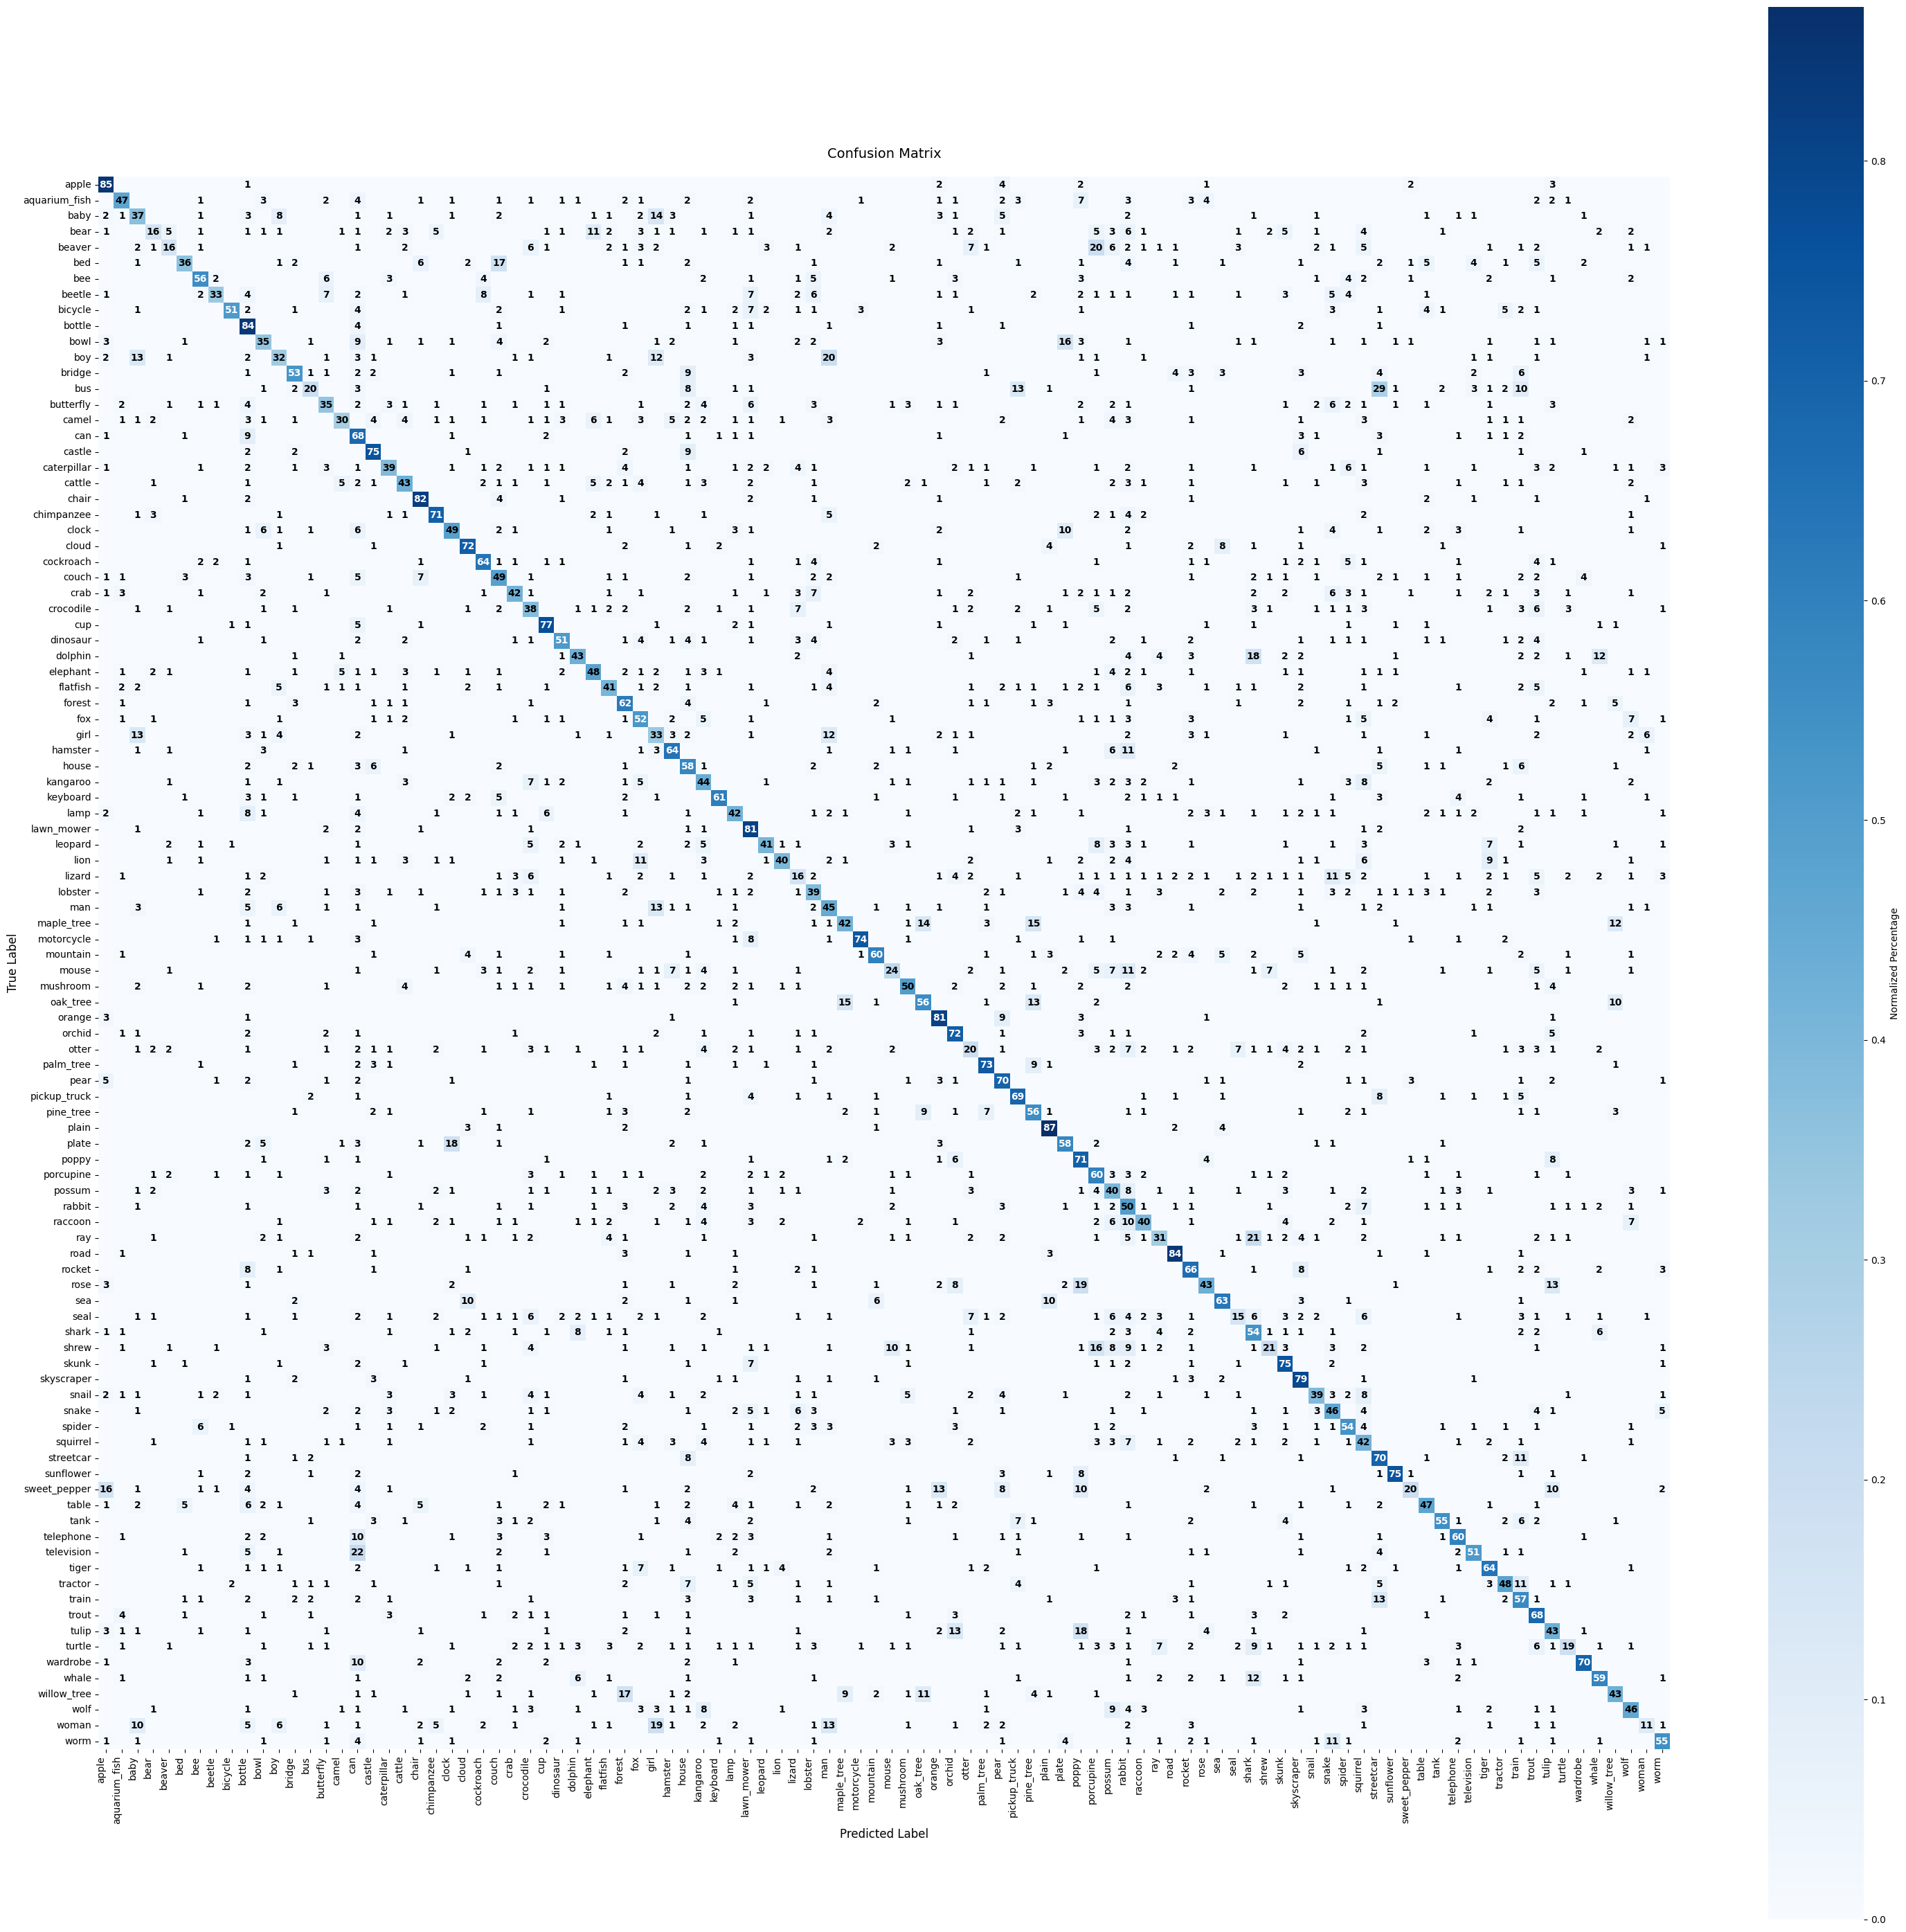

In [12]:
clean_acc, cm = evaluate(model, testloader)
plot_confusion_matrix(cm)

# Visualization (10 points)

In order to see the perturbations, you can try and visualize the images, perturbations and adversarial examples next to each other.

In [13]:
def visualize_adversarial_examples(model, x, y, attack, attack_params=dict(), n=5):
    model.eval()
    x_batch, y_batch = x.to(device), y.to(device)

    x_adv_batch = attack(model, x_batch, y_batch, **attack_params)

    fig, axes = plt.subplots(n, 3, figsize=(10, 3 * n))

    for i in range(n):
        x = x_batch[i]
        x_adv = x_adv_batch[i]
        perturbation = ((x_adv - x) / torch.max(x_adv - x) + 0.5).clamp(0, 1)

        # Get predicted labels
        pred_orig = model(x.unsqueeze(0)).argmax(dim=1).item()
        pred_adv = model(x_adv.unsqueeze(0)).argmax(dim=1).item()

        # Convert tensors to numpy for plotting
        def to_img(t):
            return t.cpu().permute(1, 2, 0).numpy()

        # Plot original
        axes[i, 0].imshow(to_img(x))
        axes[i, 0].set_title(f"Original: {classes[pred_orig]}")
        axes[i, 0].axis('off')

        # Plot perturbation
        axes[i, 1].imshow(to_img(perturbation))
        axes[i, 1].set_title("Magnified Perturbation")
        axes[i, 1].axis('off')

        # Plot adversarial
        axes[i, 2].imshow(to_img(x_adv))
        axes[i, 2].set_title(f"Adversarial: {classes[pred_adv]}")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


# DeepFool (25 points)

The [DeepFool](https://arxiv.org/abs/1511.04599) attack

In [14]:
def construct_jacobian(y, x):
    # TODO
    # Check if x requires gradient
    if not x.requires_grad:
        x.requires_grad = True

    x_grads = []
    y_flat = y.reshape(-1)  # Flatten y to handle any shape

    for i, y_element in enumerate(y_flat):

        # Check if this element requires grad and is connected to the graph
        if y_element.requires_grad and y_element.grad_fn is not None:
            # TODO
            # Compute gradient using autograd.grad
            grad = torch.autograd.grad(
                outputs=y_element,
                inputs=x,
                retain_graph=(i + 1 < len(y_flat)),
                create_graph=False,
                allow_unused=True
            )[0]

            if grad is None:
                # If grad is None, use zeros
                grad = torch.zeros_like(x)
        else:
            # If element doesn't require grad, use zeros
            grad = torch.zeros_like(x)

        x_grads.append(grad)

    # Reshape to match Jacobian shape
    return torch.stack(x_grads).reshape(*y.shape, *x.shape)

def deepfool(model, image, label, overshoot: float = 0.02):
    image.requires_grad = True

    # TODO: Forward pass to get scores and predicted label
    fs = model(image)[0]
    _, pre = torch.max(fs, dim=0)

    # TODO: Early exit if already misclassified
    if pre != label:
        return (True, pre, image)

    # TODO: Compute Jacobian of scores w.r.t. input
    ws = construct_jacobian(fs, image)
    image = image.detach()

    # TODO: Anchor class score and gradient for the true label
    f_0 = fs[label]
    w_0 = ws[label]

    # TODO: Gather scores/gradients for all non-true (wrong) classes
    wrong_classes = [i for i in range(len(fs)) if i != label]
    f_k = fs[wrong_classes]
    w_k = ws[wrong_classes]

    # TODO: Compute differences to true class (f' and w')
    f_prime = f_k - f_0
    w_prime = w_k - w_0

    # TODO: Select class with minimal |f'| / ||w'||_2
    value = torch.abs(f_prime) / torch.norm(nn.Flatten()(w_prime), p=2, dim=1)
    _, hat_L = torch.min(value, 0)

    # TODO: Compute minimal perturbation delta toward selected class
    delta = (torch.abs(f_prime[hat_L]) * w_prime[hat_L] / (torch.norm(w_prime[hat_L], p=2) ** 2))

    # TODO: Map reduced index back to original class index
    target_label = hat_L if hat_L < label else hat_L + 1

    # TODO: Apply overshoot, create adversarial image, and clamp to [0,1]
    adv_image = image + (1 + overshoot) * delta
    adv_image = torch.clamp(adv_image, min=0, max=1).detach()

    return (False, target_label, adv_image)


def deep_fool(model, images, labels, steps: int = 10, overshoot: float = 0.02):
    # TODO: Prepare inputs on device without gradients
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)

    batch_size = len(images)
    # TODO: Track which images still need perturbation and their target labels
    correct = torch.tensor([True] * batch_size)
    target_labels = labels.clone().detach().to(device)
    curr_steps = 0

    # Initialize per-image adversarial copies
    adv_images = []
    for idx in range(batch_size):
        image = images[idx : idx + 1].clone().detach()
        adv_images.append(image)

    # Iteratively update images until fooled or steps exhausted
    while (True in correct) and (curr_steps < steps):
        for idx in range(batch_size):
            if not correct[idx]:
                continue
            # TODO: Single-image DeepFool step and bookkeeping
            early_stop, pre, adv_image = deepfool(model, adv_images[idx], labels[idx], overshoot)
            adv_images[idx] = adv_image
            target_labels[idx] = pre
            if early_stop:
                correct[idx] = False

        curr_steps += 1

    # TODO: Stack final adversarial batch output
    adv_images = torch.cat(adv_images).detach()
    return adv_images


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df_args = {'steps': 10, 'overshoot': 0.02}
df_acc, df_cm = evaluate(model, testloader, deep_fool, df_args, 5)

  0%|          | 0/79 [00:00<?, ?it/s]

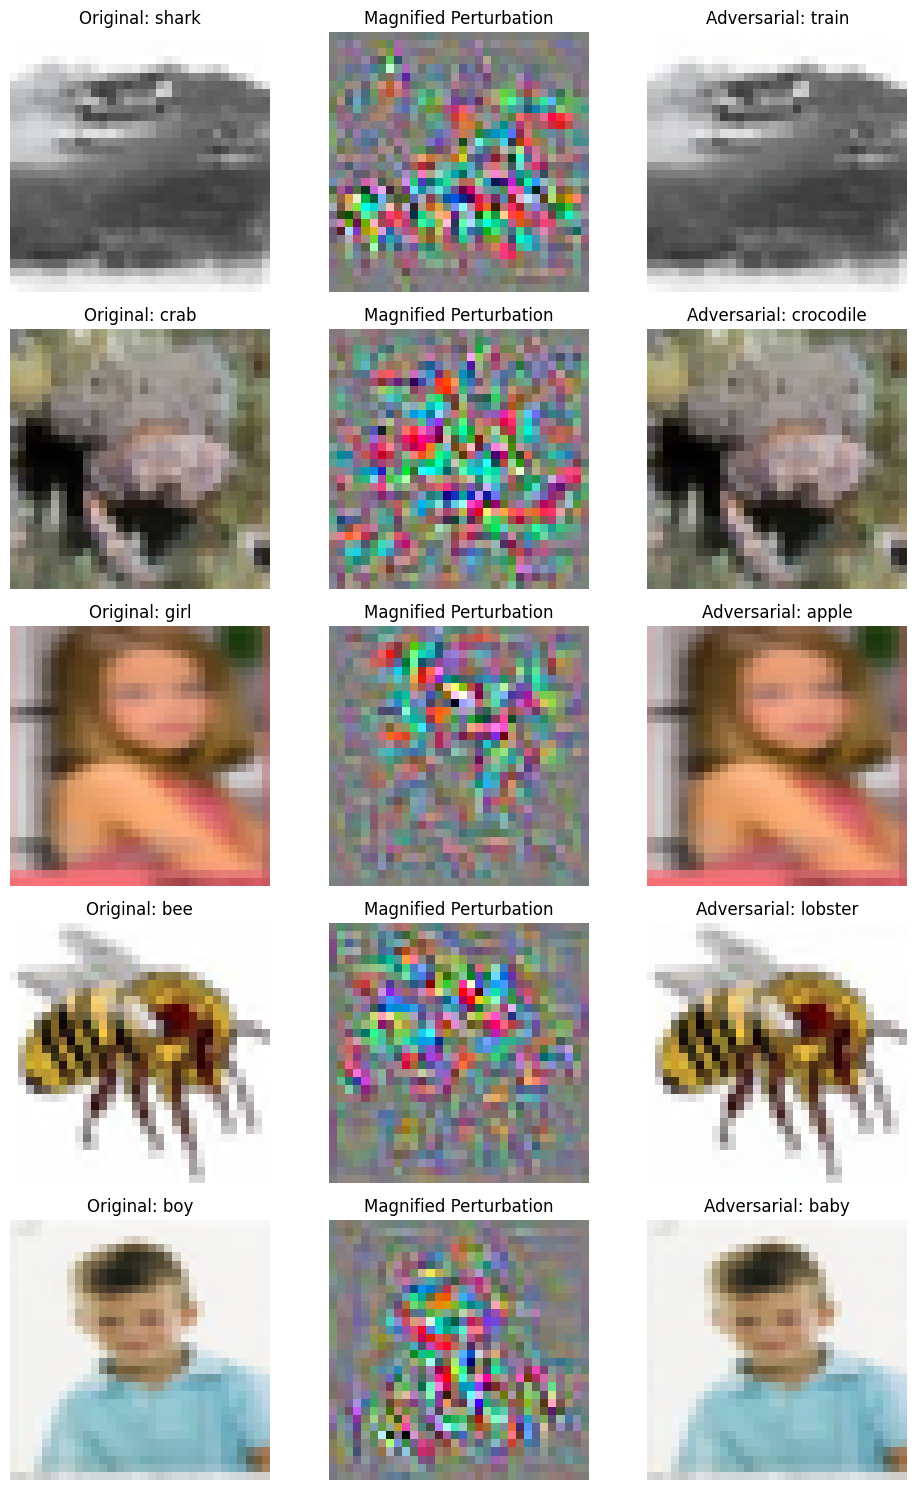

In [16]:
visualize_adversarial_examples(model, images, labels, deep_fool, df_args)

# Independence (15 points)

In [18]:
def collect_perturbations(model, loader, attack, attack_params=dict(), batch_count=-1):
    """
    Collect adversarial perturbations for SVD analysis.

    Args:
        model: The target model to attack
        loader: DataLoader providing (inputs, labels) batches
        attack: Function that generates adversarial examples

    Returns:
        perturbations: Matrix of flattened perturbations (num_samples x input_dimension)
    """
    model.eval()
    perturbations = []

    for inputs, labels in tqdm(loader, leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        # TODO: Generate adversarial examples
        adv_inputs = attack(model, inputs, labels, **attack_params)

        # TODO: Calculate perturbations
        perturbation_batch = (adv_inputs - inputs).detach().cpu()

        # TODO: Flatten perturbations and store
        for pert in perturbation_batch:
            perturbations.append(pert.flatten().numpy())

        batch_count -= 1
        if batch_count == 0:
            break

    # TODO: Convert to matrix format
    perturbation_matrix = np.vstack(perturbations)
    return perturbation_matrix

In [19]:
df_args = {'steps': 10, 'overshoot': 0.02}
perturbations = collect_perturbations(model, testloader, deep_fool, df_args, batch_count=5)

  0%|          | 0/79 [00:00<?, ?it/s]

In [20]:
U, S, Vt = np.linalg.svd(perturbations, full_matrices=False)

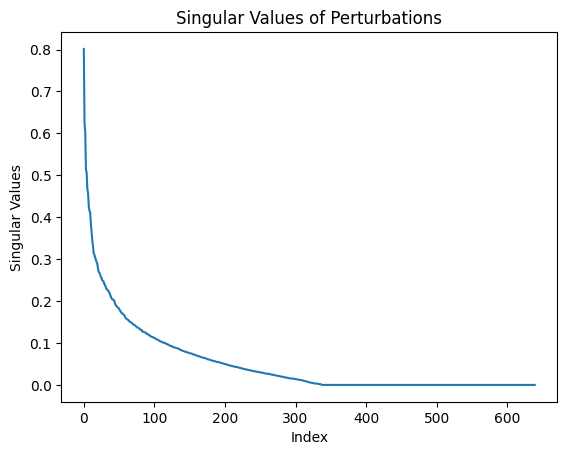

In [21]:
plt.plot(S)
plt.title('Singular Values of Perturbations')
plt.xlabel('Index')
plt.ylabel('Singular Values')
plt.show()

# Universal Adversarial Perturbations (25 points)

For a universal perturbation $v$, the attack looks like this:

In [22]:
def uap_attack(model, x, y, v):
    return x + v

Use the vector from the previous section with the highest singular value.
Report the accuracy for this vector as the universal perturbation.

  0%|          | 0/79 [00:00<?, ?it/s]

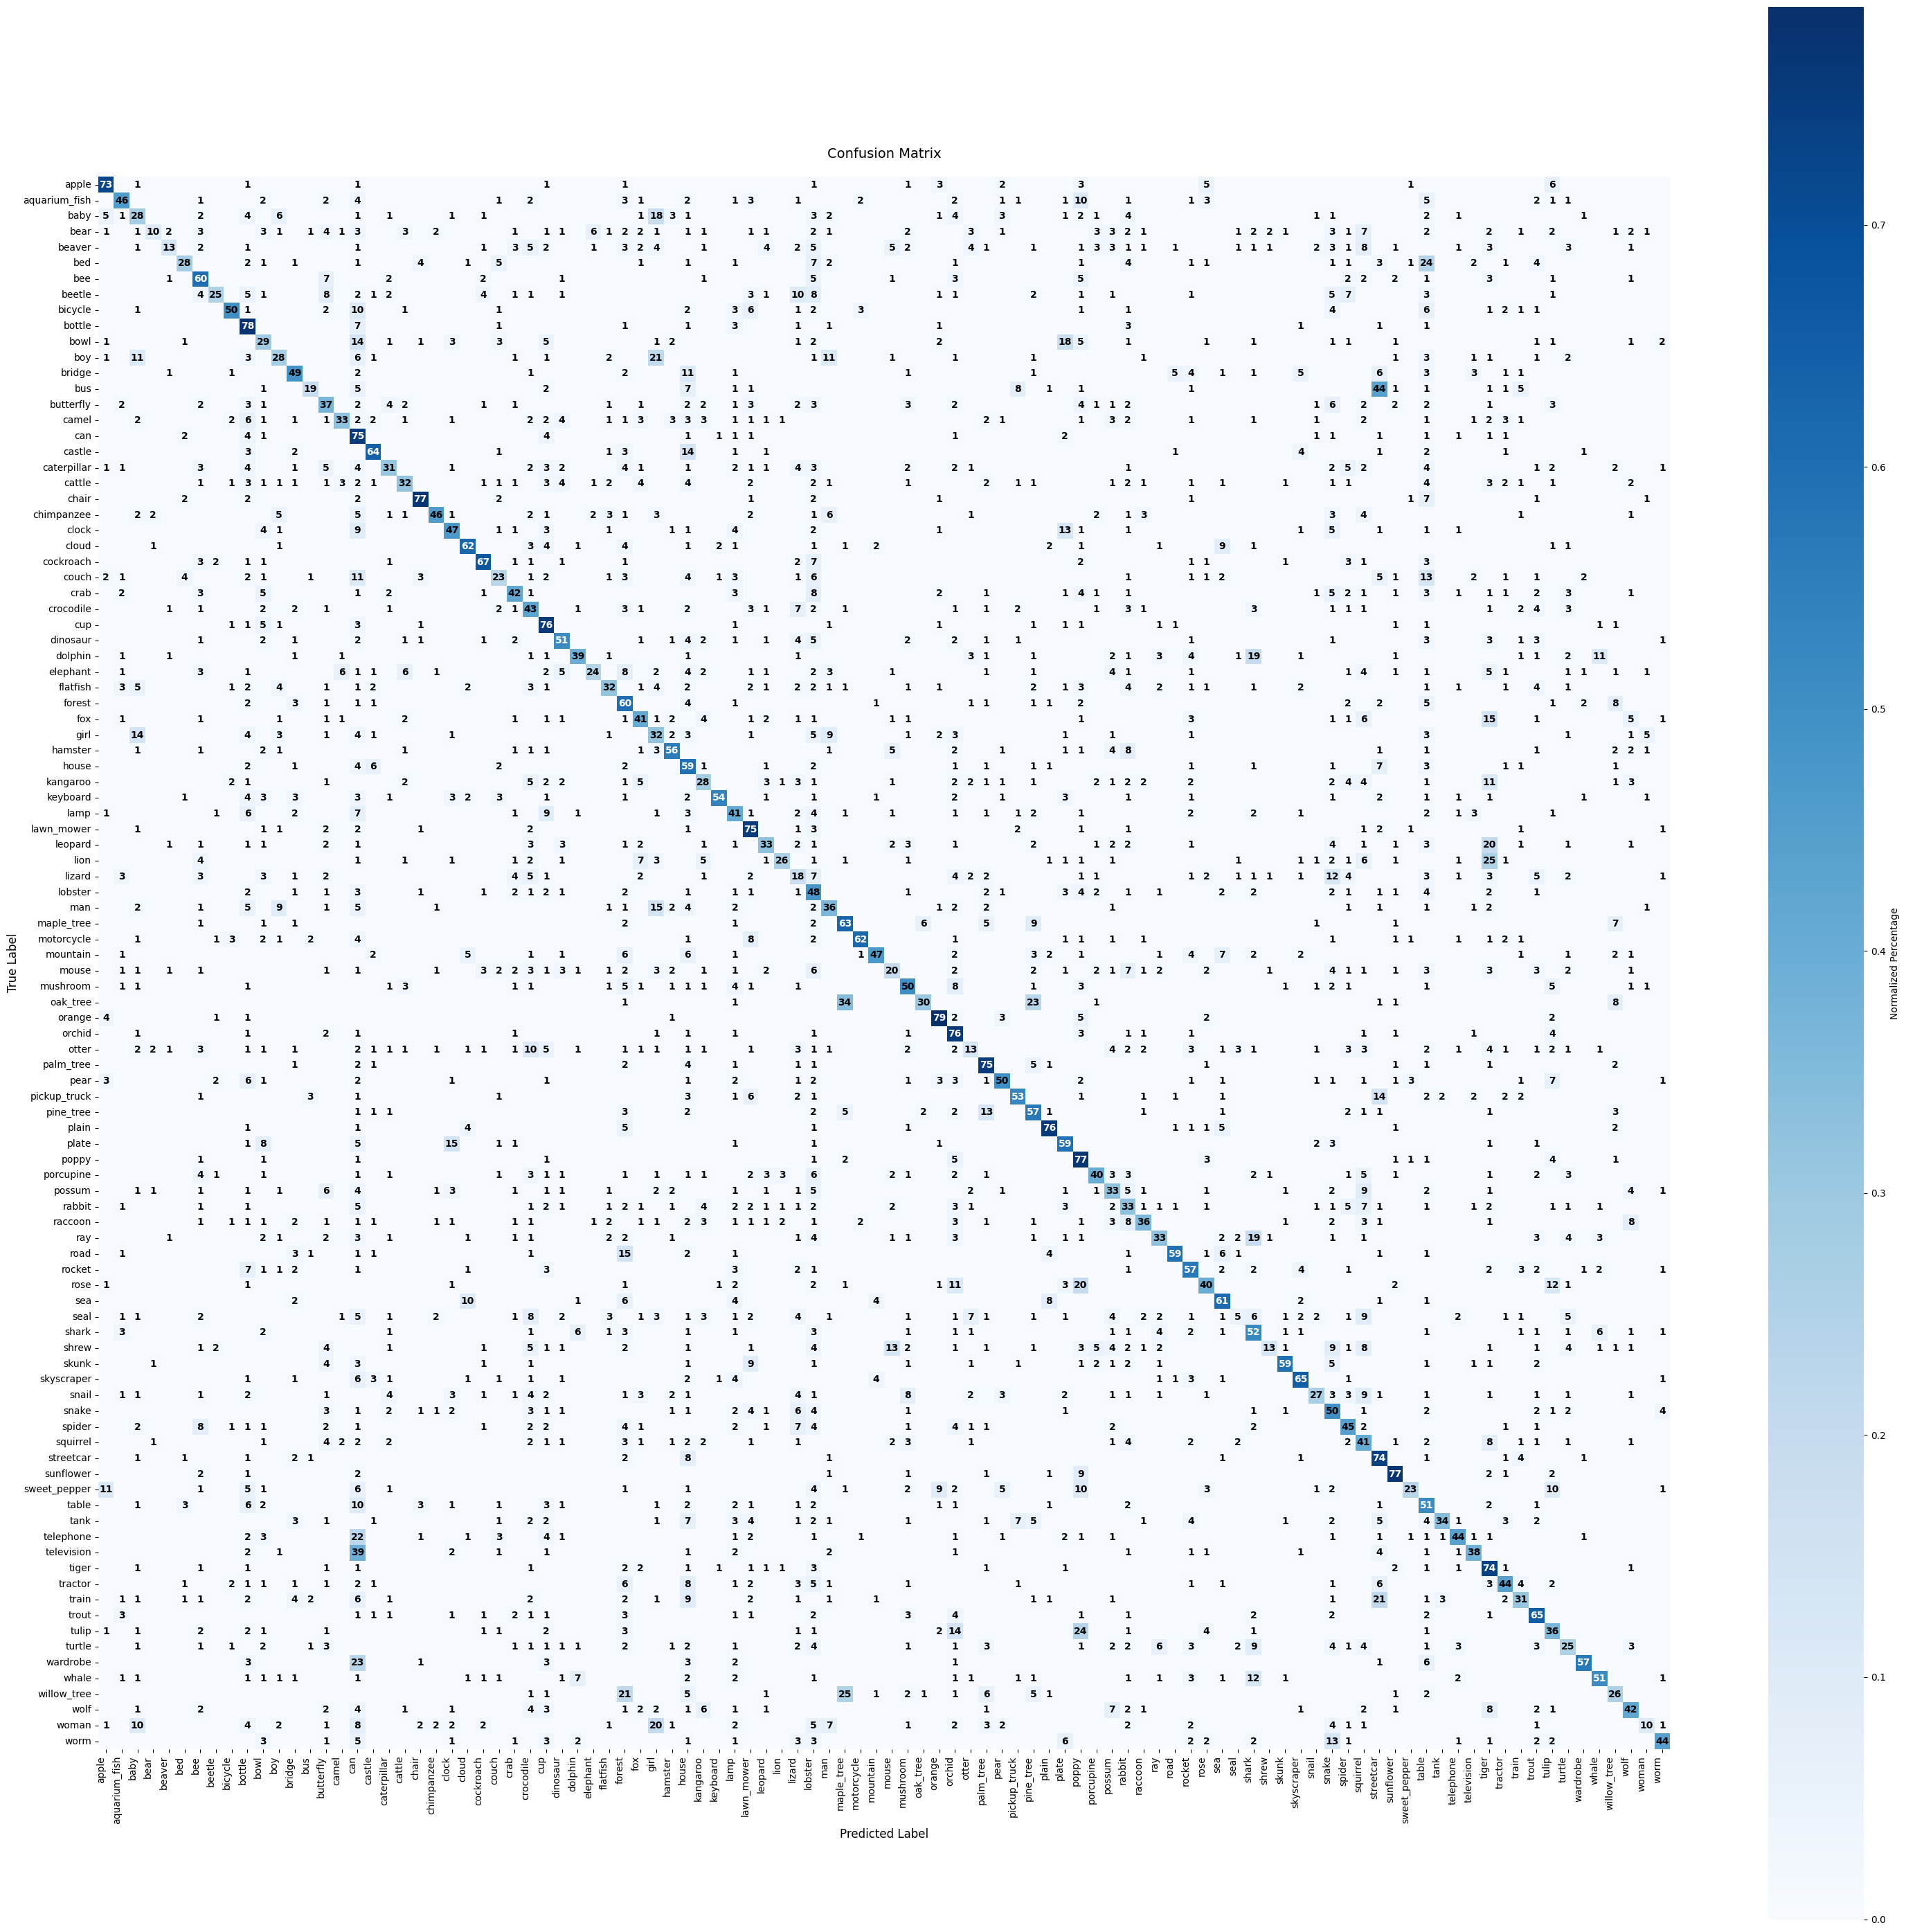

In [23]:
vector = torch.from_numpy(Vt[0]).reshape(3, 32, 32).to(device)
acc, cm = evaluate(model, testloader, uap_attack, {'v': vector})
plot_confusion_matrix(cm)

  0%|          | 0/79 [00:00<?, ?it/s]

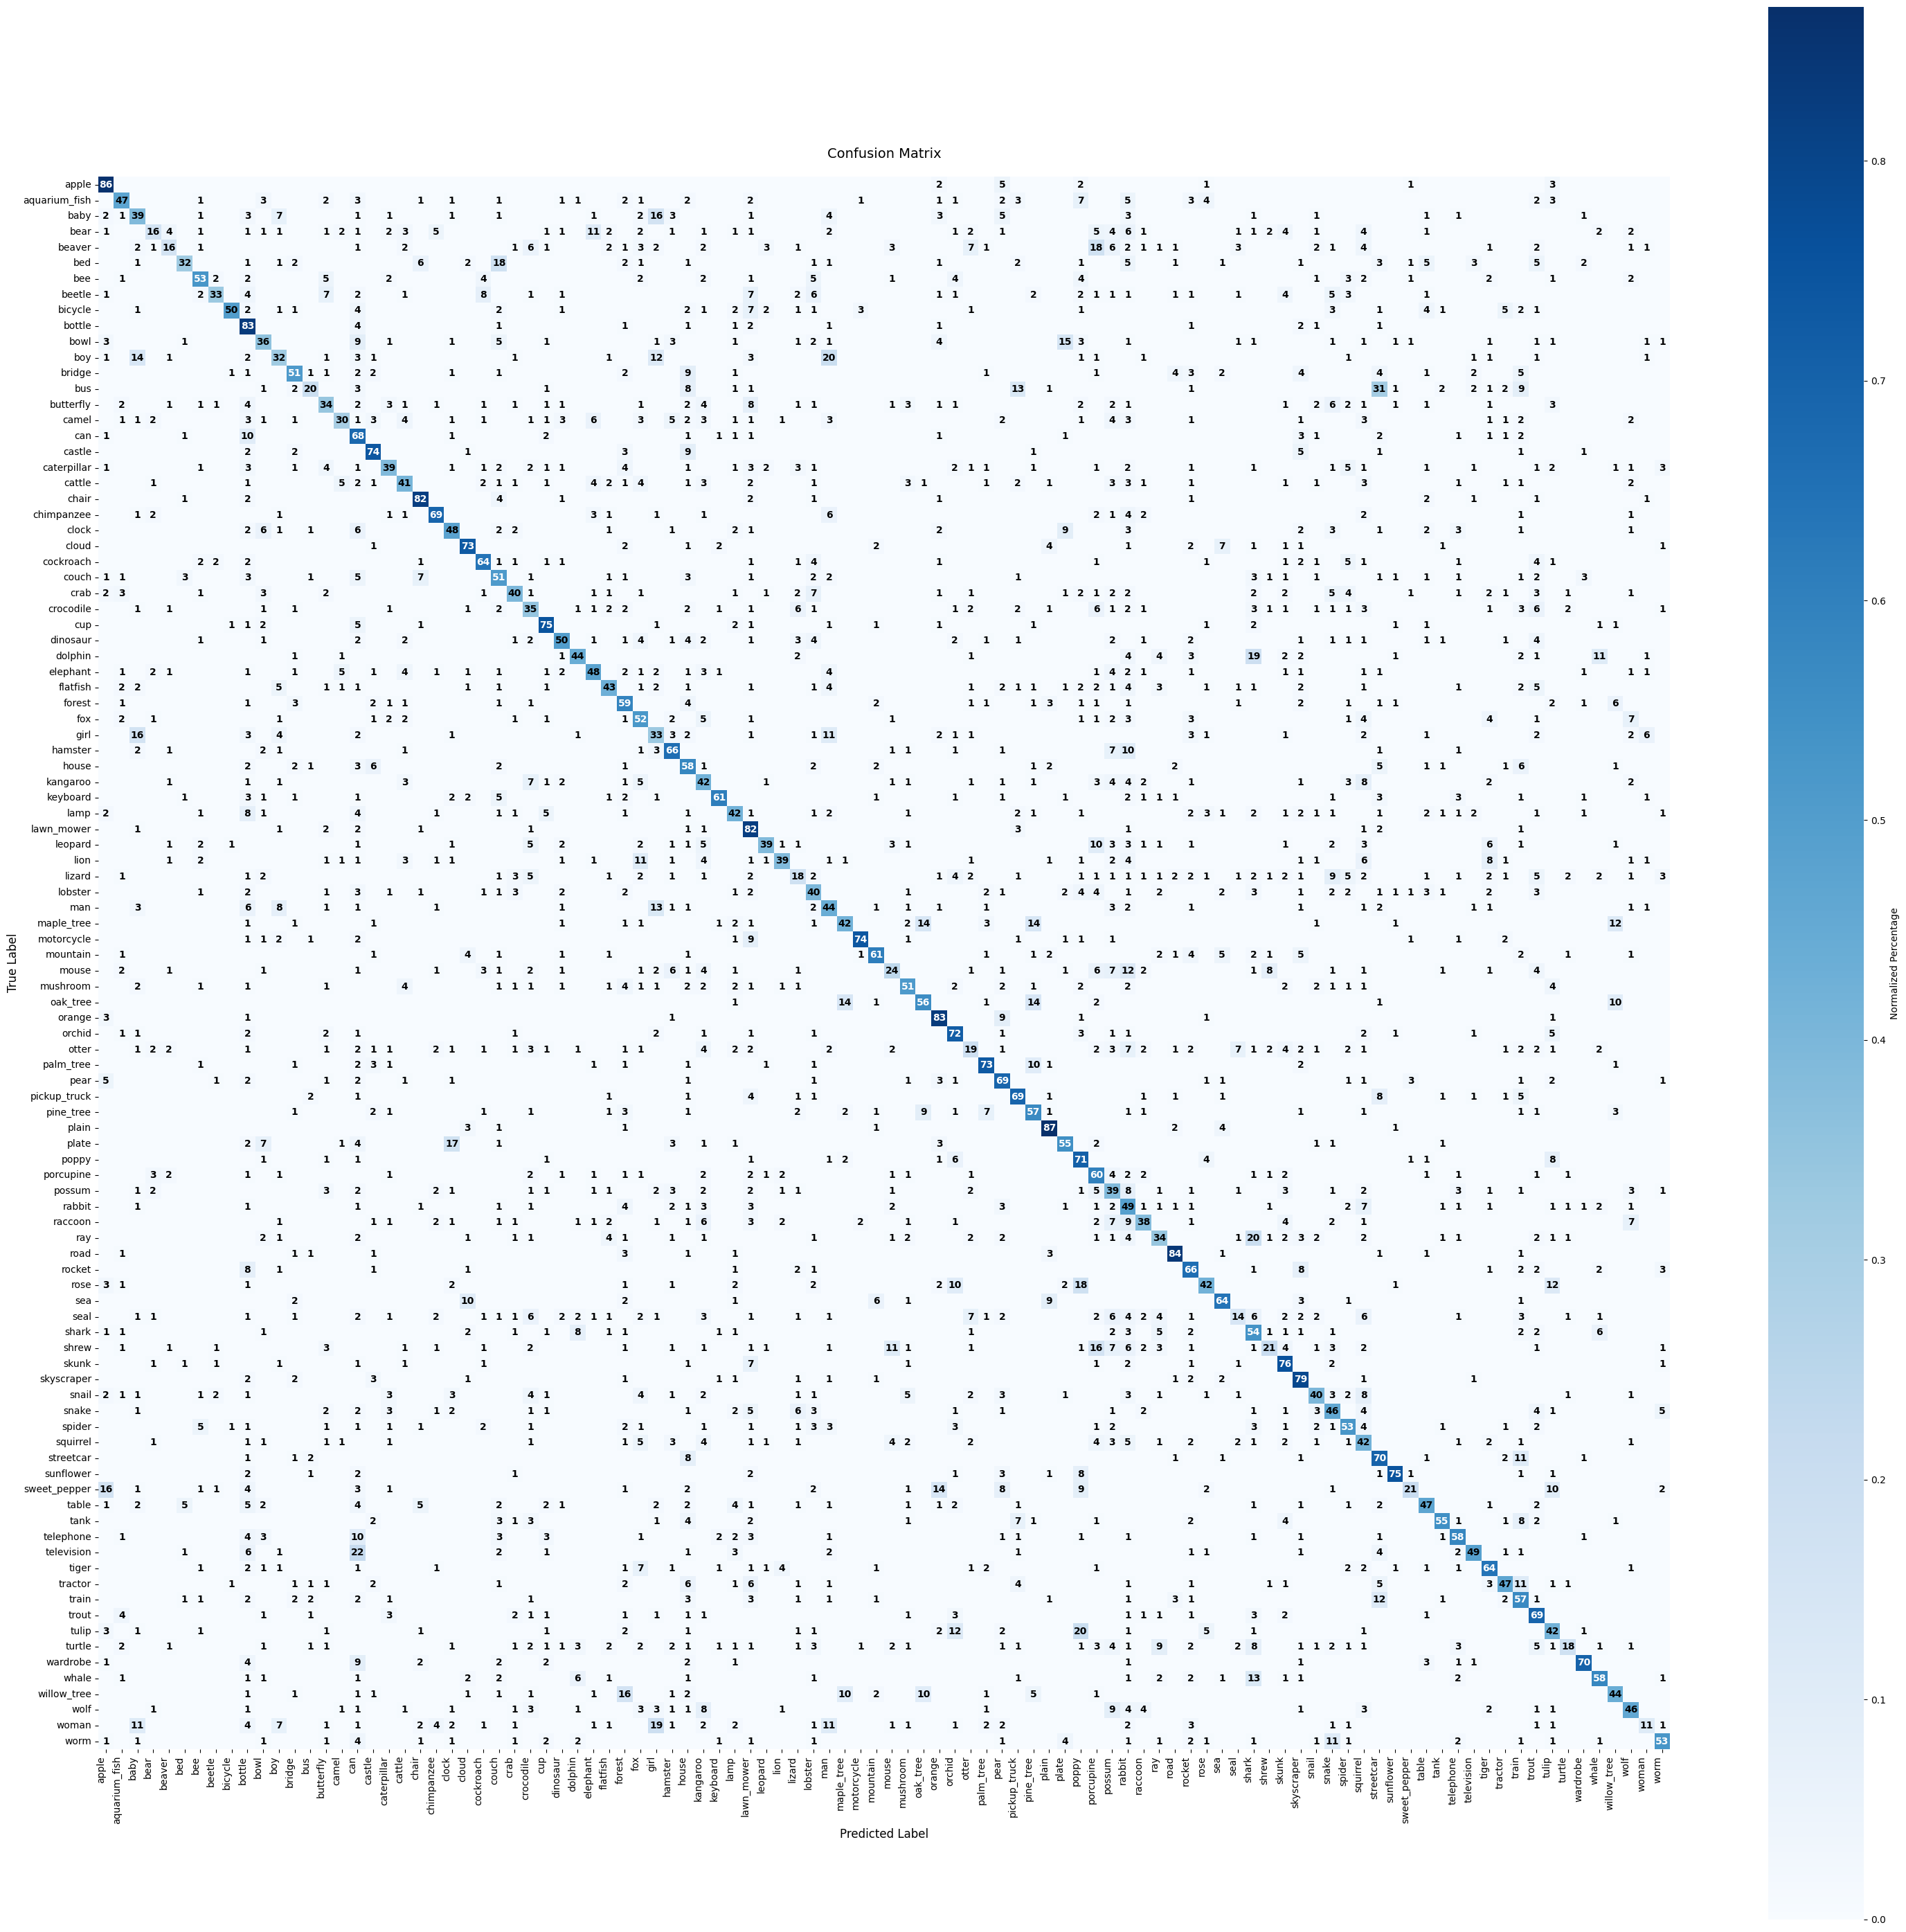

In [24]:
vector = torch.from_numpy(Vt[-1]).reshape(3, 32, 32).to(device)
acc, cm = evaluate(model, testloader, uap_attack, {'v': vector})
plot_confusion_matrix(cm)

Implement the following function to project perturbation $v$ to $L_p$ ball of radius $\xi$.
Your code should support $p=2$ and $p=\infty$.

In [25]:
def proj_lp(v, xi, p):
    if p == 2:
        # TODO
        v_norm = torch.norm(v.view(-1))
        if v_norm > xi:
            v = v * (xi / v_norm)
    elif p == np.inf:
        # TODO
        v = torch.clamp(v, -xi, xi)
    else:
        raise ValueError("p must be 2 or np.inf")
    return v

In [34]:
def universal_perturbation(model, loader, delta=0.3, max_iters=10, xi=20, p=2, attack=deep_fool, attack_params=dict()):
    """
    Universal Adversarial Perturbation implementation using DataLoader
    """
    model.to(device)
    model.eval()

    # Initialize perturbation
    sample_image, _ = next(iter(loader))
    v = torch.zeros(sample_image.shape[1:]).to(device)
    fooling_rates = []

    for _ in range(max_iters):

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            for i in range(images.shape[0]):
                image, label = images[i].unsqueeze(0), labels[i].unsqueeze(0)

                # TODO: Check if current image is already fooled
                with torch.no_grad():
                    pred = model((image + v).clamp(0,1)).argmax(1)

                if pred == label:
                    # TODO: Generate adversarial perturbation
                    pert_image = attack(model, image + v, label, **attack_params)

                    # TODO: Compute the perturbation
                    dr = pert_image - (image + v)

                    # TODO: Update universal perturbation
                    v = v + dr.squeeze()

                    # TODO: Project on Lp ball
                    v = proj_lp(v, xi, p)

            # TODO Calculate fooling rate
            acc, cm = evaluate(model, loader, attack=uap_attack, attack_params={'v': v})
            fooling_rate = 100 - acc
            fooling_rates.append(fooling_rate)
            print(f'Fooling Rate = {fooling_rate:.2f}%')
            if fooling_rate > 100 - 100 * delta:
               return v, fooling_rates

    return v, fooling_rates

In [35]:
# Assuming you have a model and DataLoader
df_args = {'steps': 10}
perturbation, fooling_rates = universal_perturbation(model, testloader, xi=20, attack_params=df_args)

  0%|          | 0/79 [00:00<?, ?it/s]

Fooling Rate = 68.13%


  0%|          | 0/79 [00:00<?, ?it/s]

Fooling Rate = 68.70%


  0%|          | 0/79 [00:00<?, ?it/s]

Fooling Rate = 63.75%


  0%|          | 0/79 [00:00<?, ?it/s]

Fooling Rate = 61.97%


  0%|          | 0/79 [00:00<?, ?it/s]

Fooling Rate = 66.08%


  0%|          | 0/79 [00:00<?, ?it/s]

Fooling Rate = 68.32%


  0%|          | 0/79 [00:00<?, ?it/s]

Fooling Rate = 68.48%


  0%|          | 0/79 [00:00<?, ?it/s]

Fooling Rate = 71.25%


  0%|          | 0/79 [00:00<?, ?it/s]

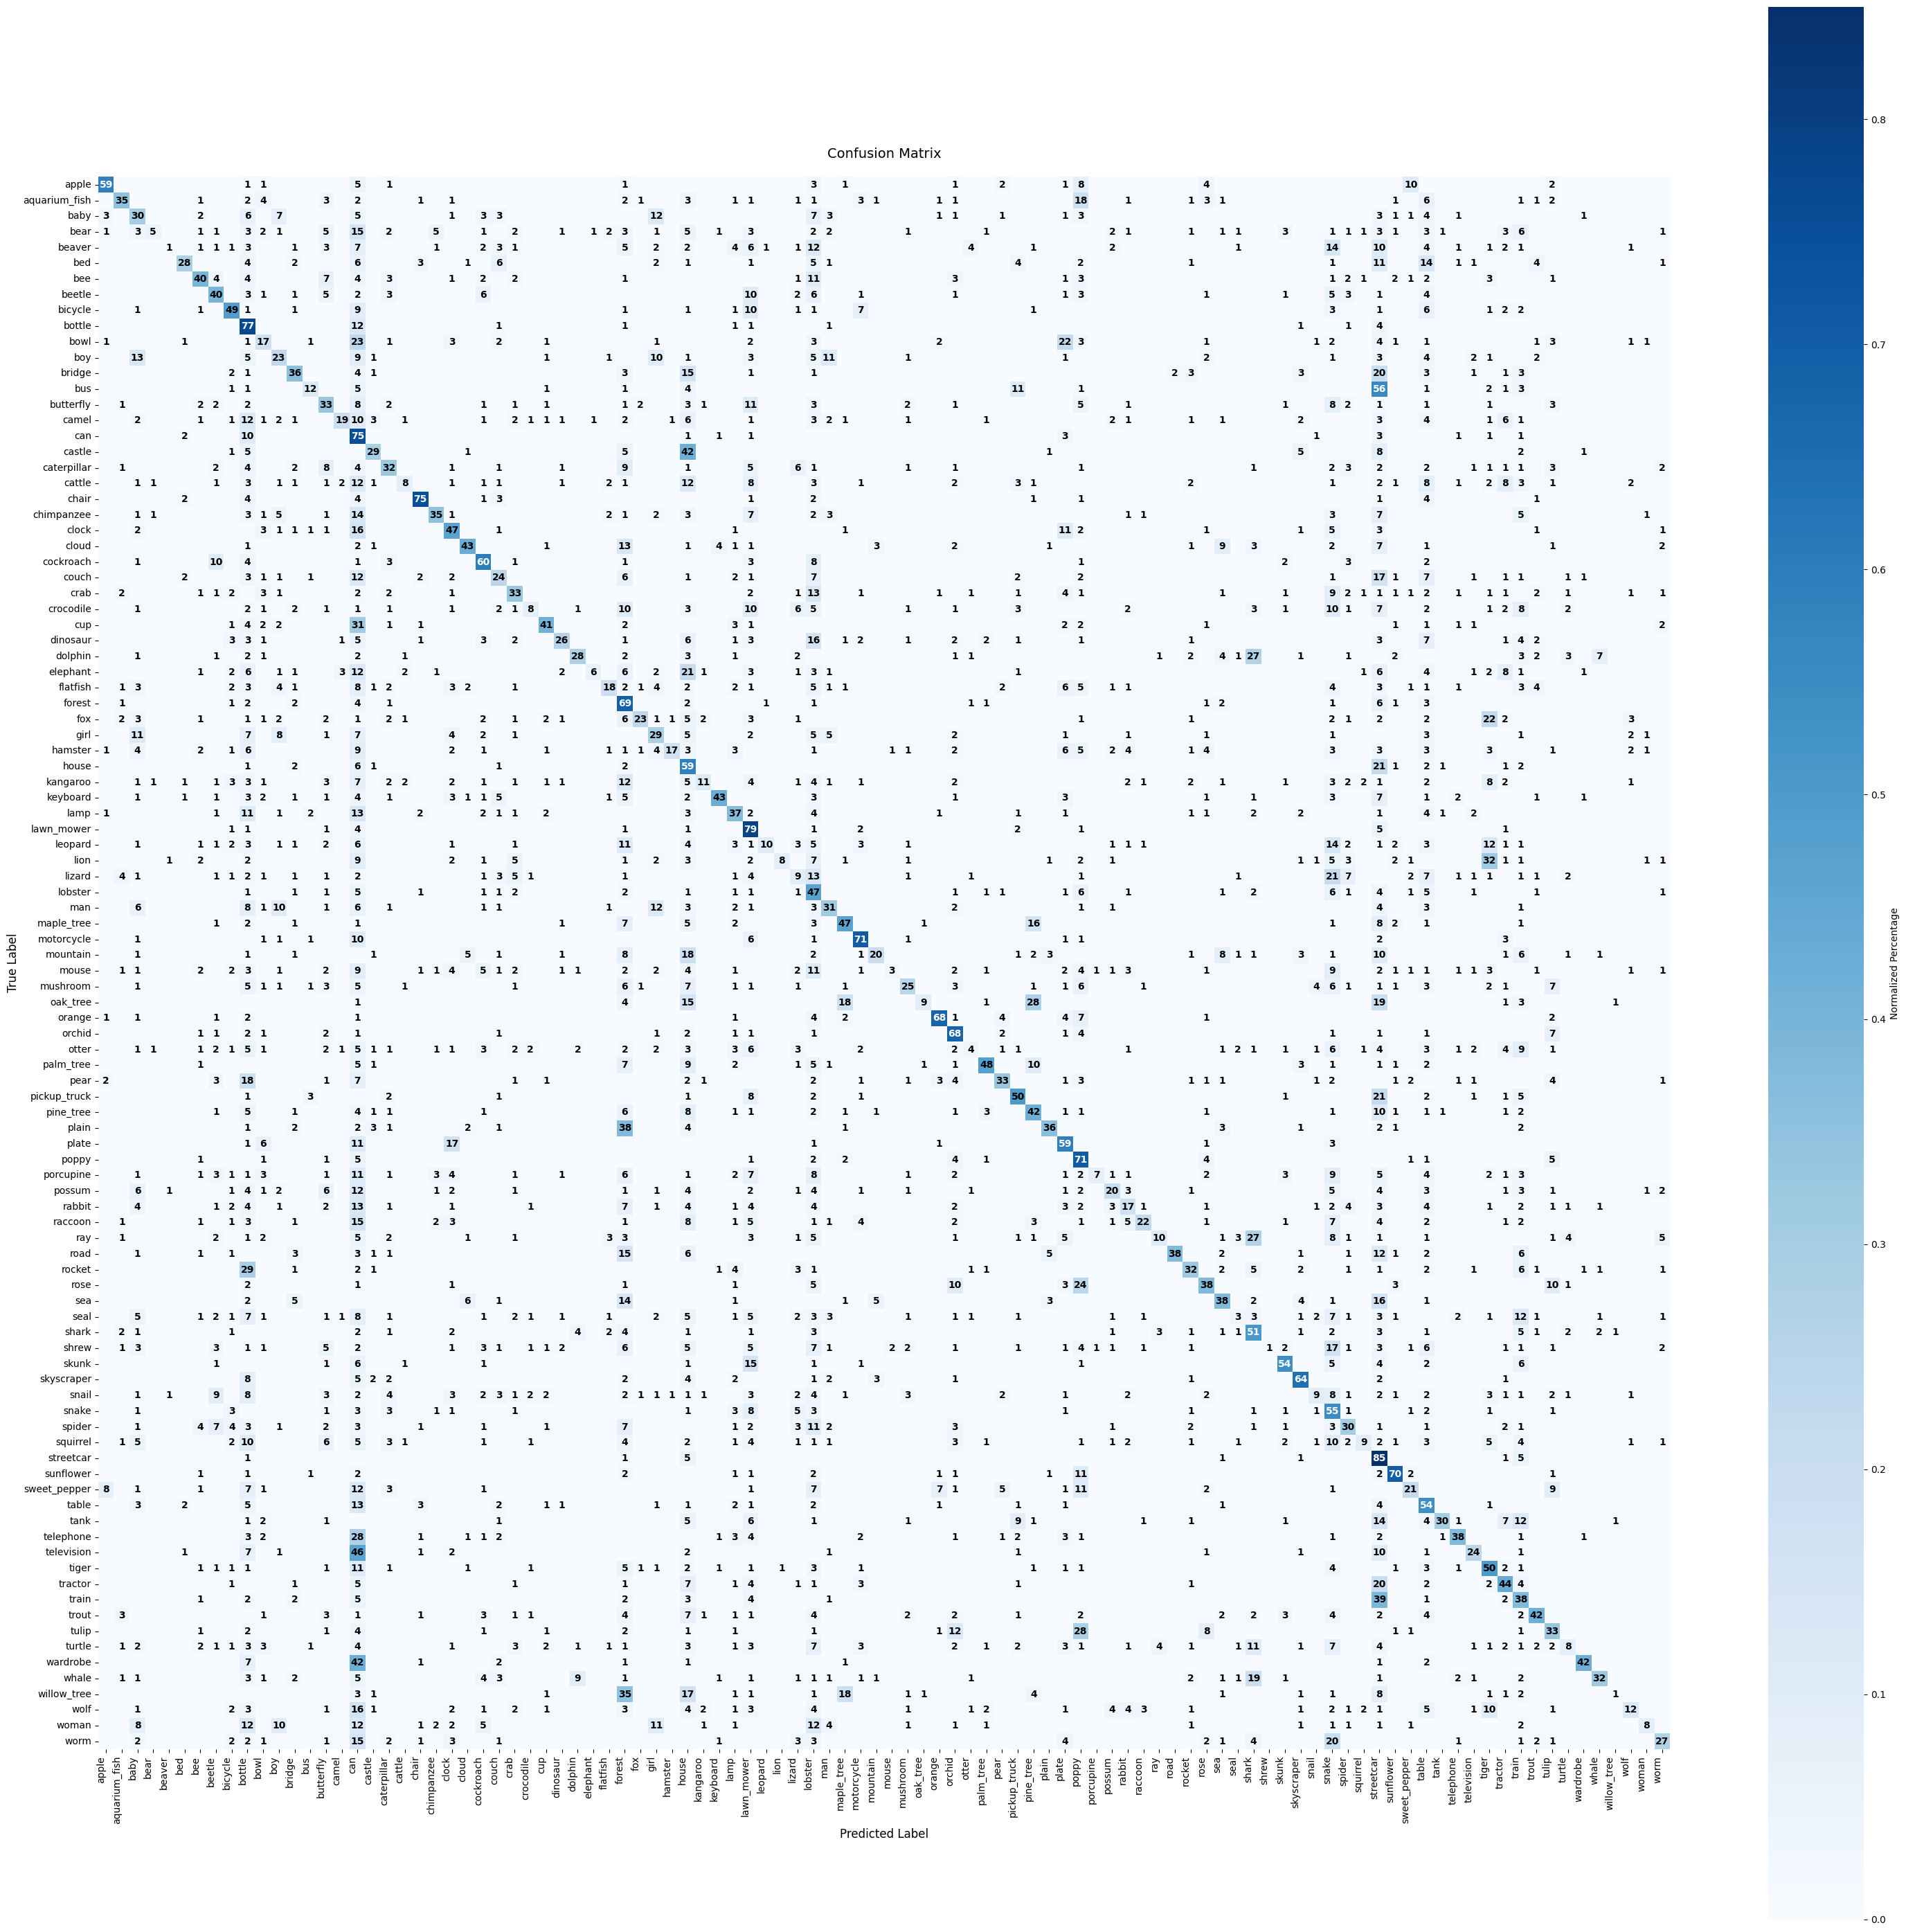

In [36]:
acc, cm = evaluate(model, testloader, uap_attack, {'v': perturbation})
plot_confusion_matrix(cm)